<h1><center>Лабораторна робота 5.</center></h1>
<h2><center>Логістична регресія й випадковий ліс в задачі кредитного скорингу</center></h2>

**Виконав:** Прізвище І.П.

**Варіант:** №__

<a class="anchor" id="lab-5"></a>

## Зміст 

- [5.1. Завантаження навчальних даних](#lab-5.1)
- [5.2. Бутстреп](#lab-5.2)  
- [5.3. Підбір параметрів для моделі логістичної регресії](#lab-5.3)
- [5.4. Визначення впливу ознак](#lab-5.4)
- [5.5. Створення моделі випадкового лісу](#lab-5.5)
- [5.6. Беггінг](#lab-5.6)

Головним завданням цієї лабораторної роботи є побудова моделі на основі машинного навчання (МН) для задачі кредитного скорингу.

<a class="anchor" id="lab-5.1"></a>

## <span style="color:blue; font-size:1.2em;">5.1. Завантаження навчальних даних</span>

[Повернутися до змісту](#lab-5)

Змінна, значення якої прогнозується, $Y$:

 - SeriousDlqin2yrs – стан невиплати людиною кредиту впроводж наступних 90 днів; можливі значення: 1 – клієнт оплачує кредит із запізненням або не виплачує взагалі, 0 – клієнт оплачує кредит вчасно. 

Незалежні ознаки, $X$:

 - age – вік позичальника кредитних коштів; тип – integer;
 - NumberOfTime30-59DaysPastDueNotWorse – кількість прострочених виплат інших кредитів більше 30-59 днів тому, але не більше впродовж останніх двох років; тип – integer;
 - DebtRatio – відношення щомісячного відрахування щодо заборгованості (кредити, аліменти тощо) до сукупного місячного доходу (percentage); тип – real;
 - MonthlyIncome – місячний дохід в доларах; тип – real;
 - NumberOfTimes90DaysLate – кількість прострочених виплат інших кредитів більше 90 днів; тип – integer;
 - NumberOfTime60-89DaysPastDueNotWorse – кількість прострочених виплат інших кредитів більш 60-89 днів, але не більше впродовж останніх двох років; тип – integer;
 - NumberOfDependents – кількість членів сім'ї позичальника; тип – integer.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# відключимо попередження Anaconda
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

In [2]:
# задамо графіки у форматі .svg, щоби вони мали кращу чіткість
%config InlineBackend.figure_format = 'svg' 

# підвищимо розмір графіків за замовчуванням
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 7, 5

Створимо функцію, яка буде замінювати NaN значення на медіану в кожному стовпчику таблиці:

In [3]:
def delete_nan(table):
    for col in table.columns:
        table[col]= table[col].fillna(table[col].median())
    return table   

Завантажуємо дані для подальшого навчання:

In [4]:
credit_scoring_url = 'https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/main/02_assignments/ida_lab-05_logit-rf-credit-scoring/credit_scoring_sample.csv'

data = pd.read_csv(credit_scoring_url, sep =';')
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


Розглянемо типи завантажених даних:

In [5]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Переглянемо розподіл класів у цільовій змінні:

Distribution of target


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

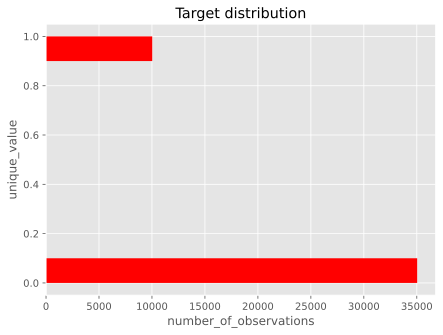

In [6]:
ax = data['SeriousDlqin2yrs'].hist(orientation='horizontal', color='red')
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print('Distribution of target')
data['SeriousDlqin2yrs'].value_counts()/data.shape[0]

Далі виберемо назви всіх ознак з таблиці, крім прогнозованого.

In [7]:
independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != 'SeriousDlqin2yrs']
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

Застосовуємо функцію, яка замінює всі NaN значення на медіанне значення відповідного стовпця.

In [8]:
table = delete_nan(data)

Розділяємо підготовлений набір даних на незалежні ознаки ($X$) та цільову ознаку ($y$).

In [9]:
X = table[independent_columns_names]
y = table['SeriousDlqin2yrs']

<a class="anchor" id="lab-5.2"></a>

## <span style="color:blue; font-size:1.2em;">5.2. Бутстреп</span>

[Повернутися до змісту](#lab-5)

Спершу обрахуйте інтервальну оцінку середнього віку (age) для надійних клієнтів та тих клієнтів, що прострочили виплату кредиту з "впевненістю" >= 90% . Використайте приклад з лекції, поставте `np.random.seed (0)`, як це зроблено в огляді.

In [10]:
# Функція для генерації підвибірок за допомогою бутстрепу
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [12]:
# Функція для інтервальної оцінки
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [13]:
churn_clients = data[data['SeriousDlqin2yrs'] == 1]['age'].values
reliable_clients = data[data['SeriousDlqin2yrs'] == 0]['age'].values

np.random.seed(0)

churn_mean_scores = [np.mean(sample) 
                     for sample in get_bootstrap_samples(churn_clients, 1000)]
reliable_mean_scores = [np.mean(sample) 
                         for sample in get_bootstrap_samples(reliable_clients, 1000)]

print("Інтервальна оцінка середнього віку клієнтів",  stat_intervals(churn_mean_scores, 0.1))
print("Інтервальна оцінка середнього віку клієнтів",  stat_intervals(reliable_mean_scores, 0.1))

Інтервальна оцінка середнього віку клієнтів [45.71379414 46.12700479]
Інтервальна оцінка середнього віку клієнтів [52.59470132 52.85480064]


### <span style="color:red; font-size:1.5em;">Завдання 1</span>


**Для варіантів 1-5:**

Обрахуйте інтервальну оцінку середнього віку надійних клієнтів з параметрами `n_samples=1000` та `alpha=0.1`. 

**Для варіантів 6-10:**

Обрахуйте інтервальну оцінку середнього віку боржників з параметрами `n_samples=1000` та `alpha=0.05`. 

**Для варіантів 11-15:**

Обрахуйте інтервальну оцінку середнього віку боржників з параметрами `n_samples=1000` та `alpha=0.05`. 

**Для варіантів 16-20:**

Обрахуйте інтервальну оцінку середнього віку надійних клієнтів з параметрами `n_samples=500` та `alpha=0.1`. 

<a class="anchor" id="lab-5.3"></a>

In [14]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, 0.05)
    return boundaries
    churn_clients = data[data['SeriousDlqin2yrs'] == 1]['age'].values

np.random.seed(0)

churn_mean_scores = [np.mean(sample) 
                     for sample in get_bootstrap_samples(churn_clients, 1000)]

print("Інтервальна оцінка середнього віку клієнтів",  stat_intervals(churn_mean_scores, 0.05))

Інтервальна оцінка середнього віку клієнтів 45.4976947935368


## <span style="color:blue; font-size:1.2em;">5.3. Підбір параметрів для моделі логістичної регресії</span>

[Повернутися до змісту](#lab-5)

Однією з важливих метрик якості моделі є значення площі під [ROC-кривої](https://uk.wikipedia.org/wiki/ROC-%D0%BA%D1%80%D0%B8%D0%B2%D0%B0) (AUC). Значення ROC-AUC лежить від 0 до 1. Чим ближче значення метрики ROC-AUC до 1, тим якісніше відбувається класифікація моделлю.

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

Використовуємо модуль [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) для побудови логістичної регресії. Через незбалансованість класів в цільовій функції додаємо параметр балансування. Також додамо параметр `random_state=5` для відтворюваності результатів.

In [16]:
lr = LogisticRegression(random_state=5, class_weight= 'balanced')

Тепер спробуємо підібрати найкращий коефіцієнт регуляризації (коефіцієнт C в логістичній регресії) для моделі логістичної регрессії. Найкраще значення параметра С забезпечить нам оптимальність моделі, яка буде добре прогнозувати значення цільової функції і водночас не буде перенавчатися. Інші параметри залишаємо за замовчуванням.

In [17]:
parameters = {'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)}

Щоби підібрати коефіцієнт регуляризації переглянемо значення ROC-AUC на Stratified крос-валідації з 5 фолдів для кожного можливого значення коефіцієнта регуляризації за допомогою функції StratifiedKFold.

In [18]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

Використайте [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) з метрикою ROC-AUC за параметром C.

### <span style="color:red; font-size:1.5em;">Завдання 2</span>


**Для варіантів 1-5:**

Яке оптимальне значення параметра С в результаті застосування `GridSearchCV()`?

**Для варіантів 6-10:**

Виведіть значення стандартного відхилення за результатами `GridSearchCV()`.

**Для варіантів 11-15:**

Чи можна вважати кращу модель стійкою? Модель вважаємо стійкою, якщо стандартне відхилення на валідації менше 0.5% (скористайтесь результатми застосування `GridSearchCV()`).

**Для варіантів 16-20:**

Виведіть значення accuracy для оптимального значення параметра С за результатами `GridSearchCV()`. 

***Примітка:*** для розв'язання завдання 2 скористайтесь методоми `grid_search.best_estimator_`, `grid_search.cv_results_`, `grid_search.best_score_`.

In [22]:
lr_grid_search = GridSearchCV(lr, parameters, n_jobs=-1, scoring ='roc_auc', cv=skf)
lr_grid_search = lr_grid_search.fit(X, y)
lr_grid_search.best_estimator_

LogisticRegression(C=0.001, class_weight='balanced', random_state=5)

In [23]:
lr_grid_search.best_score_

0.8089120626797153

**Збережіть точність кращої моделі, вона вам доводиться для наступних завдань.**

<a class="anchor" id="lab-5.4"></a>

## <span style="color:blue; font-size:1.2em;">5.4. Визначення впливу ознак</span>

[Повернутися до змісту](#lab-5)

У цьому завданні ми попрацюємо з важливістю ознак. Пам'ятаємо, що важливість ознаки визначається **абсолютним значенням її коефіцієнта**. Крім того, потрібно заздалегідь нормалізувати всі ознаки, щоб їх правильно порівняти.

In [24]:
from sklearn.preprocessing import StandardScaler

lr = LogisticRegression(C=0.001,random_state=5, class_weight='balanced')
scal = StandardScaler()
lr.fit(scal.fit_transform(X), y)

LogisticRegression(C=0.001, class_weight='balanced', random_state=5)

Обрахуємо важливість ознак:

In [25]:
pd.DataFrame({'feat': independent_columns_names,
              'coef': lr.coef_.flatten().tolist()}).sort_values(by='coef', ascending=False)

,feat,coef
1,NumberOfTime30-59DaysPastDueNotWorse,0.723427
3,NumberOfTimes90DaysLate,0.516788
4,NumberOfTime60-89DaysPastDueNotWorse,0.193558
6,NumberOfDependents,0.101443
2,DebtRatio,-0.024096
5,MonthlyIncome,-0.163146
0,age,-0.416702


### <span style="color:red; font-size:1.5em;">Завдання 3</span>


**Для варіантів 1-5:**

Обрахуйте частку впливу найменш важливої ознаки на прогноз. Для цього закодуйте та обчисліть функцію [softmax](https://en.wikipedia.org/wiki/Softmax_function).

**Для варіантів 6-10:**

Обрахуйте частку впливу найважливішої ознаки на прогноз. Для цього закодуйте та обчисліть функцію [softmax](https://en.wikipedia.org/wiki/Softmax_function).

**Для варіантів 11-15:**

Порахуйте, у скільки разів збільшаться шанси, що клієнт не виплатить кредит, якщо збільшити вік на 10 років при всіх інших рівних значеннях ознак (теоретичний розрахунок можна подивитися [тут](https://www.unm.edu/~schrader/biostat/bio2/Spr06/lec11.pdf)).

**Для варіантів 16-20:**

Порахуйте, у скільки разів збільшаться шанси, що клієнт не виплатить кредит, якщо збільшити кількість членів сім'ї позичальника на 2 людини при всіх інших рівних значеннях ознак (теоретичний розрахунок можна подивитися [тут](https://www.unm.edu/~schrader/biostat/bio2/Spr06/lec11.pdf)).

In [29]:
print((np.exp(lr.coef_[0]) / np.sum(np.exp(lr.coef_[0])))[1])

0.24129793891124493


***Примітка 1:*** Приклад реалізації функції softmax можете підчитати [тут](https://machinelearningmastery.com/softmax-activation-function-with-python/).

***Примітка 2:***

Формула, за якою обраховують у скільки разів збільшаться шанси при підвищенні знчення ознаки:

$$ \large \exp^{\beta\delta}, $$

де

$ \beta $ – значення ознаки; $ \delta $ – на скільки робимо приріст.



<a class="anchor" id="lab-5.5"></a>

## <span style="color:blue; font-size:1.2em;">5.5. Створення моделі випадкового лісу</span>

[Повернутися до змісту](#lab-5)

Ініціалізуємо випадковий ліс з **10 деревами** й збалансованими класами:

In [30]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10, n_jobs=-1, 
                            random_state=42, oob_score=True, 
                            class_weight='balanced')

Будемо шукати кращі параметри поміж набору:

In [31]:
parameters = {'max_features': [1, 2, 4], 
              'min_samples_leaf': [3, 5, 7], 
              'max_depth': [5, 10, 15]}

Робимо знову Stratified k-fold валідацію. Ініціалізація валідації має зберігатися в skf з попередніх завдань.

In [32]:
%%time
rf_grid_search = GridSearchCV(rf, parameters, n_jobs=-1, scoring ='roc_auc', cv=skf,
                             verbose=True)
rf_grid_search = rf_grid_search.fit(X, y)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
CPU times: user 1.65 s, sys: 254 ms, total: 1.9 s
Wall time: 43.9 s


### <span style="color:red; font-size:1.5em;">Завдання 4</span>


**Для варіантів 1-5:**

Відповідно до результатів класифікації за випадковим лісом, яка ознака має найбільший вплив на цільову функцію? Виведіть назву ознаки та числове значення її впливовості.

**Для варіантів 6-10:**

Порівняйте результати класифікації за логістичною регресією та випадковим лісом. Вкажіть переваги та недоліки обох підходів до розв'язування нашої задачі кредитного скорингу.

Для висновку використайте такі тези:
- менше витрачається часу на навчання моделі;
- менше параметрів для перебору;
- хороше інтерпретування ознак;
- лінійні властивості алгоритму.

**Для варіантів 11-15:**

Відповідно до результатів класифікації за випадковим лісом, яка ознака має найменший вплив на цільову функцію? Виведіть назву ознаки та числове значення її впливовості.

**Для варіантів 16-20:**

Порівняйте значення частки правильних відповідей (ЧПВ, accuracy) кращої моделі випадкового лісу з кращою моделюю логістичної регресії на валідації?

# Отже, алгоритм випадкового лісу спрацював краще для задачі скорингу. Частка вірних відповідей випадкового лісу приблизно на 5% вище. Причинами результату можна вважати - невелику кількість ознак і властивості випадкового лісу як композиції. Перевага логістичної регресії заключається у можливості проінтерпретувати вплив коефіцієнтів на результат.


<a class="anchor" id="lab-5.6"></a>

## <span style="color:blue; font-size:1.2em;">5.6. Беггінг</span>

[Повернутися до змісту](#lab-5)

Наступне завдання полягатиме у навчанні беггінга, як класифікатора (`random_state=42`).

In [33]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV

За базові класифікатори візьміть **10 логістичних регресій**. Виконайте тюнинг моделі з використанням техніки [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html). Значення параметрів для перебору дано нижче:

In [34]:
parameters = {'max_features': [1, 2, 3], 'max_samples': [0.1, 0.3, 0.5], 
              "base_estimator__C": [0.0001, 0.001, 0.01]}

In [35]:
bg = BaggingClassifier(LogisticRegression(class_weight='balanced'),
                       n_estimators=10, n_jobs=-1, random_state=42)

Позаяк перебирати всі варіанти комбінацій надто довго, поставте максимальне число ітерацій 20 для `RandomizedSearchCV`. Також не забудьте передати параметр валідації `CV` і `random_state=1`.

In [44]:
%%time
bg_random_search = RandomizedSearchCV(bg, parameters, n_jobs=-1, 
                                   scoring ='roc_auc', cv=skf, n_iter=20, random_state=1,
                                  verbose=True)

CPU times: user 26 µs, sys: 7 µs, total: 33 µs
Wall time: 37 µs


### <span style="color:red; font-size:1.5em;">Завдання 5</span>


**Для варіантів 1-10:**

Виконайте додактово тюнинг навченого беггінга за допомогою `GridSearchCV`. Порівняйте результати (ЧПВ, accuracy) тюнингу за `RandomizedSearchCV` й `GridSearchCV`; якщо значення accuracy вийшли різні, спробуйте пояснити який вплив мають `parameters` на цільову метрику.

**Для варіантів 11-20:**

Яку найкращу частку правильних відповідей (ЧПВ, accuracy) отримано за допомогою `RandomizedSearchCV`?

Дайте інтерпретацію кращих параметрів для беггінга. Чому саме такі значення виявилися кращими?

In [ ]:
bg_random_search = bg_random_search.fit(X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [ ]:
bg_random_search.best_score_